In [1]:
import matplotlib.pyplot as plt # Import the Matplotlib package
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
 
import numpy as np # Import the Numpy package
 
from remap import remap2 # Import the Remap function
 
# from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
 
import datetime # Library to convert julian day to dd-mm-yyyy
 
from matplotlib.patches import Rectangle # Library to draw rectangles on the plot
 
from netCDF4 import Dataset # Import the NetCDF Python interface

import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable

import osr

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)


In [2]:
root_dir = r'C:\Projects\RD\OPIR_GOES\GOES\ABI-L1b-RadC\2017\282\05'
root_dir = r'C:\Projects\RD\OPIR_GOES\GOES\from_jeff'
root_dir = r'C:\Projects\RD\OPIR_GOES\durango_416'
b6_paths = glob.glob(root_dir + r'\OR_ABI-L1b-RadC-M3C06_G16_*')
b7_paths = glob.glob(root_dir + r'\OR_ABI-L1b-RadC-M3C07_G16_*')

# print(b6_paths)
# print(len(b6_paths))

In [24]:
# store some variables
time_ls = []
data_ls = []
grid_ls = []
date_ls = []

ind=23
for path in [b6_paths[ind]]:
     
    # Getting information from the file name ==============================================================
    # Search for the Scan start in the file name
    Start = (path[path.find("_s")+2:path.find("_e")])
    # Search for the GOES-16 channel in the file name
    Band = int((path[path.find("M3C" or "M4C")+3:path.find("_G16")]))
    # Create a GOES-16 Bands string array
    Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
     
    # Converting from julian day to dd-mm-yyyy
    year = int(Start[0:4])
    dayjulian = int(Start[4:7]) - 1 # Subtract 1 because the year starts at "0"
    dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
    date = dayconventional.strftime('%d-%b-%Y') # Format the date according to the strftime directives
    date_ls.append(date)
    
    time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan
    time_ls.append(time)
    
    # Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
    if Band <= 6:
        Unit = "Reflectance"
    else:
        Unit = "Brightness Temperature [°C]"

    # Open the file using the NetCDF4 library
    nc = Dataset(path)
     
    # Get the latitude and longitude image bounds
    geo_extent = nc.variables['geospatial_lat_lon_extent']
    min_lon = float(geo_extent.geospatial_westbound_longitude)
    max_lon = float(geo_extent.geospatial_eastbound_longitude)
    min_lat = float(geo_extent.geospatial_southbound_latitude)
    max_lat = float(geo_extent.geospatial_northbound_latitude)
     
    # Choose the visualization extent (min lon, min lat, max lon, max lat)
    #extent = [-85.0, -5.0, -60.0, 12.0]
    extent = [min_lon, min_lat, max_lon, max_lat]
     
    # Choose the image resolution (the higher the number the faster the processing is)
    resolution = 2.0
     
    # Calculate the image extent required for the reprojection
    H = nc.variables['goes_imager_projection'].perspective_point_height
    x1 = nc.variables['x_image_bounds'][0] * H
    x2 = nc.variables['x_image_bounds'][1] * H
    y1 = nc.variables['y_image_bounds'][1] * H
    y2 = nc.variables['y_image_bounds'][0] * H
     
    # Call the reprojection function
    ## DEBUG try some different projections
    targetPrj = osr.SpatialReference()
    targetPrj.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
#     targetPrj.ImportFromProj4('+proj=lcc +lon_0=-90')
    raw,grid = remap2(path, extent, resolution, x1, y1, x2, y2, targetPrj)
    grid_ls.append(grid)
     
    # Read the data returned by the function
    if Band <= 6:
        data = grid.ReadAsArray()
    else:
        # If it is an IR channel subtract 273.15 to convert to ° Celsius
        data = grid.ReadAsArray() - 273.15
        
    data_ls.append(data)

PROJCS["unnamed",
    GEOGCS["unnamed ellipse",
        DATUM["unknown",
            SPHEROID["unnamed",6378137,298.2572221]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Geostationary_Satellite"],
    PARAMETER["central_meridian",-75],
    PARAMETER["satellite_height",35786023],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    EXTENSION["PROJ4","+proj=geos +h=35786023.0 +a=6378137.0 +b=6356752.31414 +f=0.00335281068119356027489803406172 +lat_0=0.0 +lon_0=-75.0 +sweep=x +no_defs"]]


In [25]:
# store some variables
time_ls7 = []
data_ls7 = []
grid_ls7 = []
date_ls7 = []

for path in [b7_paths[ind]]:
     
    # Getting information from the file name ==============================================================
    # Search for the Scan start in the file name
    Start = (path[path.find("_s")+2:path.find("_e")])
    # Search for the GOES-16 channel in the file name
    Band = int((path[path.find("M3C" or "M4C")+3:path.find("_G16")]))
    # Create a GOES-16 Bands string array
    Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
     
    # Converting from julian day to dd-mm-yyyy
    year = int(Start[0:4])
    dayjulian = int(Start[4:7]) - 1 # Subtract 1 because the year starts at "0"
    dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
    date = dayconventional.strftime('%d-%b-%Y') # Format the date according to the strftime directives
    date_ls7.append(date)
    
    time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan
    time_ls7.append(time)
    
    # Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
    if Band <= 6:
        Unit = "Reflectance"
    else:
        Unit = "Brightness Temperature [°C]"

    # Open the file using the NetCDF4 library
    nc = Dataset(path)
     
    # Get the latitude and longitude image bounds
    geo_extent = nc.variables['geospatial_lat_lon_extent']
    min_lon = float(geo_extent.geospatial_westbound_longitude)
    max_lon = float(geo_extent.geospatial_eastbound_longitude)
    min_lat = float(geo_extent.geospatial_southbound_latitude)
    max_lat = float(geo_extent.geospatial_northbound_latitude)
     
    # Choose the visualization extent (min lon, min lat, max lon, max lat)
    #extent = [-85.0, -5.0, -60.0, 12.0]
    extent = [min_lon, min_lat, max_lon, max_lat]
     
    # Choose the image resolution (the higher the number the faster the processing is)
    resolution = 2.0
     
    # Calculate the image extent required for the reprojection
    H = nc.variables['goes_imager_projection'].perspective_point_height
    x1 = nc.variables['x_image_bounds'][0] * H
    x2 = nc.variables['x_image_bounds'][1] * H
    y1 = nc.variables['y_image_bounds'][1] * H
    y2 = nc.variables['y_image_bounds'][0] * H
     
    # Call the reprojection function
    ## DEBUG try some different projections
    targetPrj = osr.SpatialReference()
    targetPrj.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
#     targetPrj.ImportFromProj4('+proj=lcc +lon_0=-90')
    raw,grid = remap2(path, extent, resolution, x1, y1, x2, y2, targetPrj)
    grid_ls7.append(grid)
     
    # Read the data returned by the function
    if Band <= 6:
        data = grid.ReadAsArray()
    else:
        # If it is an IR channel subtract 273.15 to convert to ° Celsius
        data = grid.ReadAsArray() - 273.15
        
    data_ls7.append(data)

PROJCS["unnamed",
    GEOGCS["unnamed ellipse",
        DATUM["unknown",
            SPHEROID["unnamed",6378137,298.2572221]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Geostationary_Satellite"],
    PARAMETER["central_meridian",-75],
    PARAMETER["satellite_height",35786023],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    EXTENSION["PROJ4","+proj=geos +h=35786023.0 +a=6378137.0 +b=6356752.31414 +f=0.00335281068119356027489803406172 +lat_0=0.0 +lon_0=-75.0 +sweep=x +no_defs"]]


In [5]:
nc.variables['goes_imager_projection'], 1./298.2572221

(<class 'netCDF4._netCDF4.Variable'>
 int32 goes_imager_projection()
     long_name: GOES-R ABI fixed grid projection
     grid_mapping_name: geostationary
     perspective_point_height: 35786023.0
     semi_major_axis: 6378137.0
     semi_minor_axis: 6356752.31414
     inverse_flattening: 298.2572221
     latitude_of_projection_origin: 0.0
     longitude_of_projection_origin: -75.0
     sweep_angle_axis: x
 unlimited dimensions: 
 current shape = ()
 filling on, default _FillValue of -2147483647 used, 0.0033528106811935607)

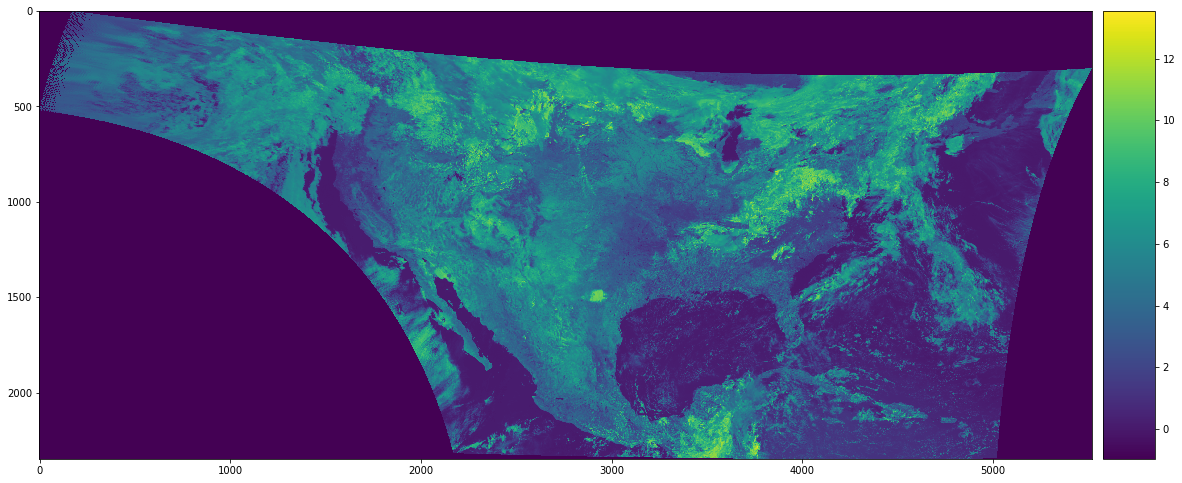

In [6]:
fig, ax = plt.subplots(figsize = (20,10))
img = ax.imshow(data_ls[0])
colorbar(img)
plt.show()

In [26]:
r7,c7 = 1125, 1811
r6, c6 = 2243, 2059

def getGeoT(extent, nlines, ncols):
    # Compute resolution based on data dimension
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]

gt = getGeoT([x1,y1,x2,y2], data_ls[0].shape[0], data_ls[0].shape[1])
print(gt)

x7 = gt[0] + gt[1]*c7
y7 = gt[3] + gt[5]*r7
x7,y7

# project to WGS84
from pyproj import Proj, transform


inProj = Proj('+proj=geos +h=35786023.0 +a=6378137.0 +b=6356752.31414 +f=0.00335281068119356027489803406172 +lat_0=0.0 +lon_0=-75.0 +sweep=x +no_defs')
outProj = Proj(init='epsg:4326')
x0,y0 = x7,y7
xp,yp = transform(inProj,outProj,x0,y0)
print (yp, xp)

[-3627271.3152550682, 907.78098230297735, 0, 4589199.7391722053, 0, -1280.2495846618713]
31.076606954812448 -97.20485918256823


In [23]:
r7

1125

In [8]:
# help(grid)
gtf = grid_ls[0].GetGeoTransform()
print(gtf)

# lat/lon of c/r
print(c7,r7)
lon7 = gtf[0] + gtf[1]*c7
lat7 = gtf[3] + gtf[5]*r7
print(lat7,lon7)

lon6 = gtf[0] + gtf[1]*c6
lat6 = gtf[3] + gtf[5]*r6
print(lat6, lon6)

Xgeo = gtf[0] + c7*gtf[1] + r7*gtf[2]
Ygeo = gtf[3] + c7*gtf[4] + r7*gtf[5]
print(Xgeo, Ygeo)

(-152.10928344726562, 0.01796745843571108, 0.0, 56.761451721191406, 0.0, -0.017968531564715774)
1811 1125
36.54685371088616 -119.57021622019286
16.45803542153393 -115.11428652813652
-119.57021622019286 36.54685371088616


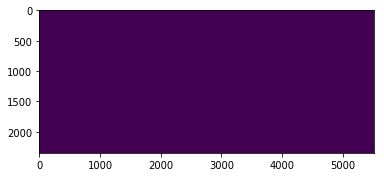

In [9]:
# make the list into an array (time will be dim=0)
data_arr = np.array(data_ls)    

# make an array of zeros to match
shp = data_ls[0].shape
targets = np.zeros((shp[0]*shp[1],1))

# reshape
data_arr = np.rollaxis(data_arr, 0, 3)
data_vec = np.reshape(data_arr, (shp[0]*shp[1], -1))

# make into a pandas data frame
import pandas as pd
        
dts = []
for i,t in enumerate(time_ls):
    s = 'UTC_' + t.replace(':','').replace(' ','').replace('UTC', '')
    dt = (s, 'float32')    
    dts.append(dt)
    
# restructure the numpy array for use in a pandas dataframe
myRecord = np.core.records.array(list(tuple(data_vec.transpose())), dtype=dts)
df = pd.DataFrame(myRecord)


absmax = data_vec.max(axis=1).max()
loc = np.where(data_vec.max(axis=1) == absmax)[0]

targets[loc]=1
plt.imshow(np.reshape(targets, (shp[0], shp[1])))
plt.show()

#### Write out one of the rasters

In [27]:
from osgeo import gdal, osr
driver = gdal.GetDriverByName('GTiff')
rows,cols = data_ls7[0].shape

fname = dts[0][0] + "_" + date_ls[0].replace('-','') + '_GOES_L1B_RAD_Durango_mod7.tif'
dst_ds = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
dst_ds.SetGeoTransform(grid_ls7[0].GetGeoTransform())
#srs = osr.SpatialReference()
#srs.ImportFromWkt(projInfo)
dst_ds.SetProjection(grid_ls7[0].GetProjection()) 

# Write out_arr to band
dst_ds.GetRasterBand(1).WriteArray(data_ls7[0])

# Flush to disk and close file
dst_ds.FlushCache()
dst_ds = None

